In [1]:
! pip install statsmodels
! pip install pmdarima

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
time: 1.67 s (started: 2021-12-26 09:14:15 +00:00)


In [2]:
from preprocessing import GetData
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from pmdarima.arima import ndiffs
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


get_data = GetData(Path('./dataset'))
t_list = get_data.get_ticker_list()
print(t_list)

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF-B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DL

In [3]:
# energy sector
energy_list = ['APA', 'COG', 'COP', 'CVX', 'DVN', 'EOG', 'FANG', 'HAL', 'HES', 'KMI', 'MPC', 'MRO', 'NOV', 'OKE', 'OXY', 'PSX', 'PXD', 'SLB', 'VLO', 'WMB', 'XOM']

obj_ticker = 'APA'
price_type = 'Close'
apa_price_df = get_data.get_price_data(price_type=price_type, ticker_list=[obj_ticker])
display(apa_price_df)

,Ticker,Close
2009-12-31,APA,103.169998
2010-01-04,APA,105.870003
2010-01-05,APA,107.120003
2010-01-06,APA,108.800003
2010-01-07,APA,107.150002
...,...,...
2021-06-08,APA,23.139999
2021-06-09,APA,22.840000
2021-06-10,APA,22.680000
2021-06-11,APA,22.629999


time: 7.15 s (started: 2021-12-26 09:14:18 +00:00)


In [4]:
class EDA:
    def __init__(self, price_df, obj_ticker, price_type):
        self.obj_ticker = obj_ticker
        self.price_type = price_type
        self.price_df = price_df
        
        
    def draw_ori_price(self):
        plt.figure(figsize=(10,6))
        plt.grid(True)
        plt.xlabel('Dates', fontsize=14)
        plt.ylabel(f'{self.price_type} Prices', fontsize=14)
        plt.plot(self.price_df[self.price_type])
        plt.title(f'{self.obj_ticker} closing price', fontsize=19)
        plt.show()
   

    def test_stationarity(self):
        '''
        adfuller:
            Null hypothesis: Non Stationarity exists in the series.
            Alternative Hypothesis: Stationarity exists in the series
            
            adf （float）: 测试统计, Critical value of the data in your case
            pvalue （float） : Probability that null hypothesis will not be rejected(p-value), MacKinnon基于MacKinnon的近似p值（1994年，2010年）
            usedlag （int）: 使用的滞后数量, Number of lags used in regression to determine t-statistic. So there are no auto correlations going back to '0' periods here.
            nobs（ int）: 用于ADF回归的观察数和临界值的计算, Number of observations used in the analysis.
            critical values（dict）: 测试统计数据的临界值为1％，5％和10％。基于MacKinnon（2010）, values corresponding to adfuller test.
            icbest（float）: 如果autolag不是None，则最大化信息标准。
            resstore （ResultStore，可选）: 一个虚拟类，其结果作为属性附加
            -------------------------------------------------------------------------------
            如何确定该序列能否平稳呢？主要看：
                - 1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设
                  以股票APA，adf结果为-1.42， 大于三个level的统计值。所以是不平稳的，需要进行一阶差分后，再进行检验。
                  adf critical value > critical values(t-values at 1%,5%and 10% confidence intervals), null hypothesis cannot be rejected. So there is non stationarity in your data

                - P-value是否非常接近0，接近0，则是平稳的，否则，不平稳。
                  Also p-value of 0.35>0.05(if we take 5% significance level or 95% confidence interval), null hypothesis cannot be rejected.

            ref:
                - https://blog.csdn.net/weixin_42746776/article/details/103723615
                - https://www.itbook5.com/2019/08/11560/
                - https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results
        '''
        
        timeseries = self.price_df[self.price_type]
        #Determing rolling statistics
        rolmean = timeseries.rolling(12).mean()
        rolstd = timeseries.rolling(12).std()
        rolemean50 = timeseries.rolling(50).mean()
        rolstd50 = timeseries.rolling(50).std()
        #Plot rolling statistics:
        plt.figure(figsize=(10,6))
        plt.plot(timeseries, color='blue',label='Original')
        plt.plot(rolmean, color='red', label='Rolling Mean')
        plt.plot(rolstd, color='green', label = 'Rolling Std')
        plt.plot(rolemean50, color='magenta', marker='o', label='Rolling Mean 50')
        plt.plot(rolstd50, color='purple', marker='x',label = 'Rolling Std 50')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.show(block=False)

        print("Results of dickey fuller test")
        adft = adfuller(timeseries,autolag='AIC')
        output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used']) 
        for key,values in adft[4].items():
            output[f'critical value ({key})'] =  values
        print(output)

        d =  ndiffs(timeseries, test="adf") # 差分次數
        print('*='*50)
        if (adft[0]>0.05 or adft[0] > adft[4]['10%'] or adft[0] > adft[4]['5%'] or adft[0] > adft[4]['1%']):
            print(f'{self.obj_ticker}\'s {timeseries.name} is not stationary, and d for arima is {d}')
        else:
            print(f'{self.obj_ticker}\'s {timeseries.name} is stationary, and the suggest d for arima is {d}')
        print('*='*50)
        

    def seasonal_decompose(self, period):
        '''
        period : input a number of frequence period
        '''
        season_de = seasonal_decompose(self.price_df[self.price_type], model='multiplicative', period = period)
        fig = plt.figure()  
        fig = season_de.plot()  
        fig.set_size_inches(16, 9)
        fig.text(0.45,1 ,f"period_{period}",fontsize=32)
        plt.show()
        
    def draw_pacf(self, ndiff):
        '''
        ndiff : number of diff
        '''
        #  觀察PACF圖，參數是差分之後的資料
        if ndiff:
            plot_pacf(self.price_df[self.price_type].diff(ndiff))
            plt.show()
        else:
            plot_pacf(self.price_df[self.price_type])
            plt.show()

    def draw_acf(self, ndiff):
        '''
        ndiff : number of diff
        '''
        #  觀察ACF圖，參數是差分之後的資料
        if ndiff:
            plot_acf(self.price_df[self.price_type].diff(ndiff))
            plt.show()
        else:
            plot_acf(self.price_df[self.price_type])
            plt.show()

time: 2.01 ms (started: 2021-12-26 09:14:25 +00:00)


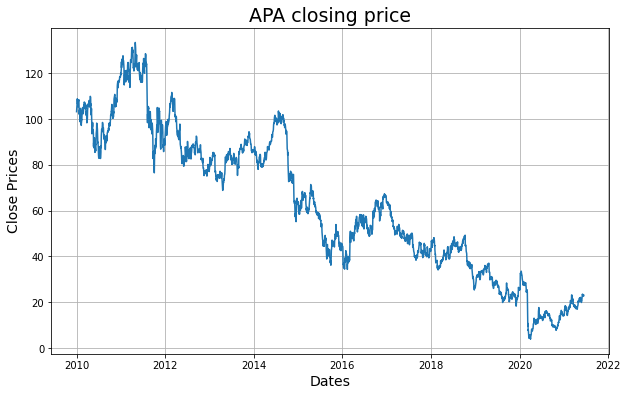

------------------------------------------------------------------------------------------------------------------------------------------------------


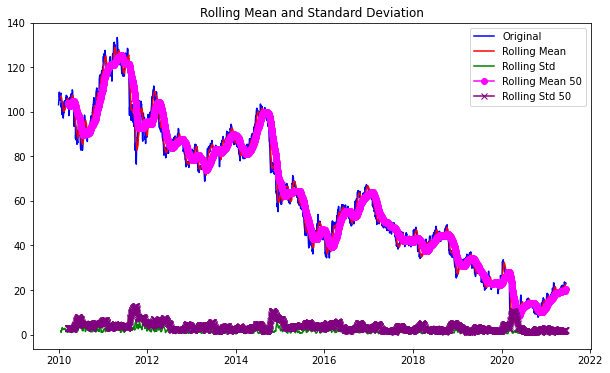

Results of dickey fuller test
Test Statistics                  -1.339148
p-value                           0.611077
No. of lags used                  6.000000
Number of observations used    2875.000000
critical value (1%)              -3.432627
critical value (5%)              -2.862546
critical value (10%)             -2.567305
dtype: float64
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
APA's Close is not stationary, and d for arima is 0
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
------------------------------------------------------------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

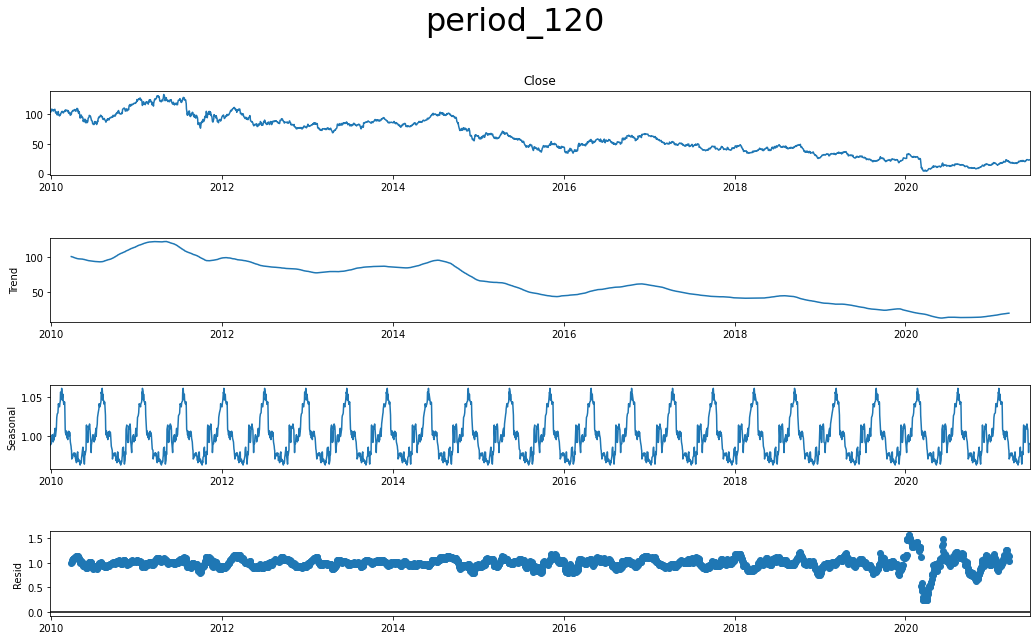

------------------------------------------------------------------------------------------------------------------------------------------------------
time: 610 ms (started: 2021-12-26 09:14:25 +00:00)


In [5]:
apa_eda = EDA(apa_price_df, obj_ticker, price_type)
apa_eda.draw_ori_price()
print("-"*150)
apa_eda.test_stationarity()
print("-"*150)
apa_eda.seasonal_decompose(120)
print("-"*150)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


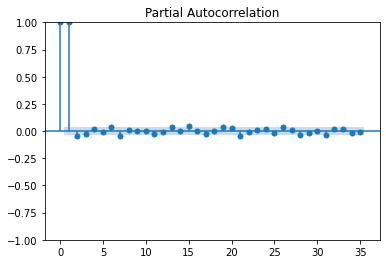

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


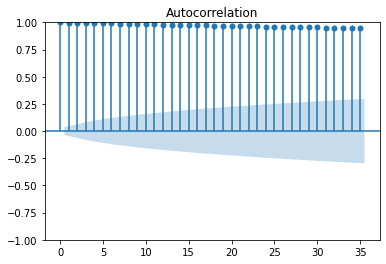

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
time: 165 ms (started: 2021-12-26 09:14:26 +00:00)


In [6]:
apa_eda.draw_pacf(0)
print("-"*150)
apa_eda.draw_acf(0)
print("-"*150)

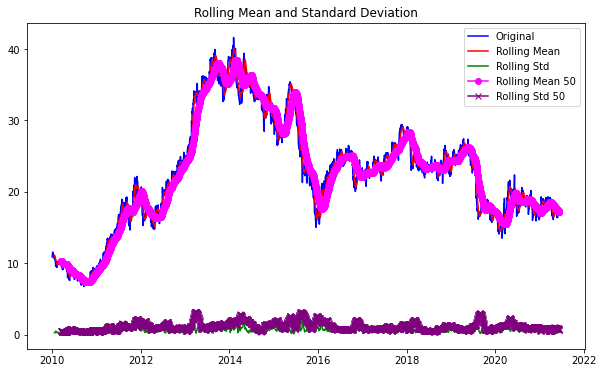

Results of dickey fuller test
Test Statistics                  -1.922113
p-value                           0.321731
No. of lags used                  1.000000
Number of observations used    2880.000000
critical value (1%)              -3.432623
critical value (5%)              -2.862544
critical value (10%)             -2.567305
dtype: float64
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
COG's Close is not stationary, and d for arima is 1
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
time: 7.41 s (started: 2021-12-26 09:14:26 +00:00)


In [7]:
obj_ticker = 'COG'
price_type = 'Close'
cog_price_df = get_data.get_price_data(price_type=price_type, ticker_list=[obj_ticker])
cog_eda = EDA(cog_price_df, obj_ticker, price_type)
cog_eda.test_stationarity()

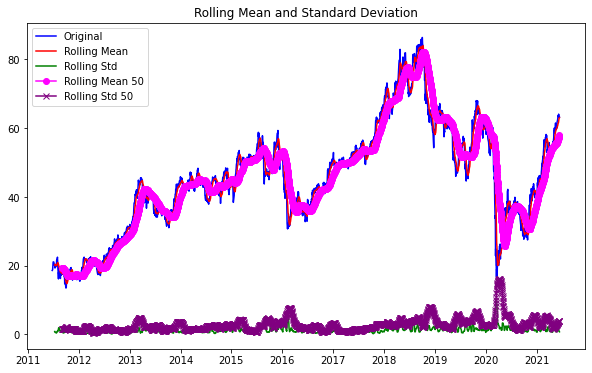

Results of dickey fuller test
Test Statistics                  -2.155650
p-value                           0.222734
No. of lags used                  7.000000
Number of observations used    2501.000000
critical value (1%)              -3.432967
critical value (5%)              -2.862696
critical value (10%)             -2.567386
dtype: float64
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
MPC's Close is not stationary, and d for arima is 1
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
time: 7.44 s (started: 2021-12-26 09:15:06 +00:00)


In [9]:
obj_ticker = 'MPC'
price_type = 'Close'
mpc_price_df = get_data.get_price_data(price_type=price_type, ticker_list=[obj_ticker])
mpc_eda = EDA(mpc_price_df, obj_ticker, price_type)
mpc_eda.test_stationarity()